In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import fftpack

In [2]:
(xTrain,yTrain),(xTest,yTest)=tf.keras.datasets.mnist.load_data()

In [3]:
def init2dDCT():

    dctmtx=fftpack.dct(np.eye(xTrain.shape[1]))
    dctmtx=dctmtx/np.sqrt(np.sum(dctmtx**2,axis=0))
    dctmtx2d=np.kron(dctmtx,dctmtx)
    return(dctmtx2d)

In [4]:
def displayDictGrid(dict):
    k=0
    grid_c=[]
    for i in range(28):
        grid_r=[]
        for j in range(28):
            grid_r.append(dict[:,k].reshape(28,28))
            k+=1
        grid_c.append(np.concatenate(grid_r,axis=1))
    plt.imshow(np.concatenate(grid_c,axis=0))


In [32]:
def preprocData(dSet):
    dSetRes=dSet.reshape(dSet.shape[0],-1).T/255.0
    dSetMean=np.mean(dSetRes,axis=1).reshape(-1,1)
    return(dSetRes,dSetMean)
xTrainPreproc,trainSetMean=preprocData(xTrain)
#xTrainPreproc-=trainSetMean
xTestPreproc,_=preprocData(xTest)
#xTestPreproc-=trainSetMean

In [33]:
class sparseOrthoTransformTrainer:
    def __init__(self,trainData,spp,numIter,dictInit=None):
        if(dictInit is None):
            randSel=np.random.RandomState(2500).permutation(xTrainPreproc.shape[1])[:1001]
            dictInit,_,_=np.linalg.svd(xTrainPreproc[:,randSel])
        else:
            dictInit=dictInit
        self.spp=spp
        self.err=np.zeros((numIter,1))
        self.trainData=trainData
        self.dict=dictInit
        self.numIter=numIter
    def spCode(self):
        proj=self.dict.T@self.trainData
        proj_s=np.sort(np.abs(proj),axis=0)[-self.spp,:]
        proj=proj*(np.abs(proj)>=proj_s)
        self.proj=proj
    def dictUpdate(self):
        mat=self.proj@self.trainData.T
        u,_,v=np.linalg.svd(mat)
        self.dict=v.T@u.T
    def fitDict(self,dispInt=0):
        print('Training')
        for i in range(self.numIter):
            self.spCode()
            self.err[i]=np.mean((self.trainData-self.dict@self.proj)**2)
            if(i%dispInt==0):
                print(f'Iteration:{i} Error:{self.err[i][0]:0.4f}')
            self.dictUpdate()
 
spp=70
numIter=100
TrainDict=sparseOrthoTransformTrainer(xTrainPreproc,spp,numIter,init2dDCT())
TrainDict.fitDict(dispInt=10)

Training
Iteration:0 Error:0.0122
Iteration:10 Error:0.0054
Iteration:20 Error:0.0043
Iteration:30 Error:0.0037
Iteration:40 Error:0.0034
Iteration:50 Error:0.0032
Iteration:60 Error:0.0031
Iteration:70 Error:0.0030
Iteration:80 Error:0.0029
Iteration:90 Error:0.0028


Text(0.5, 1.0, 'Learned dictionary 2D DCT init')

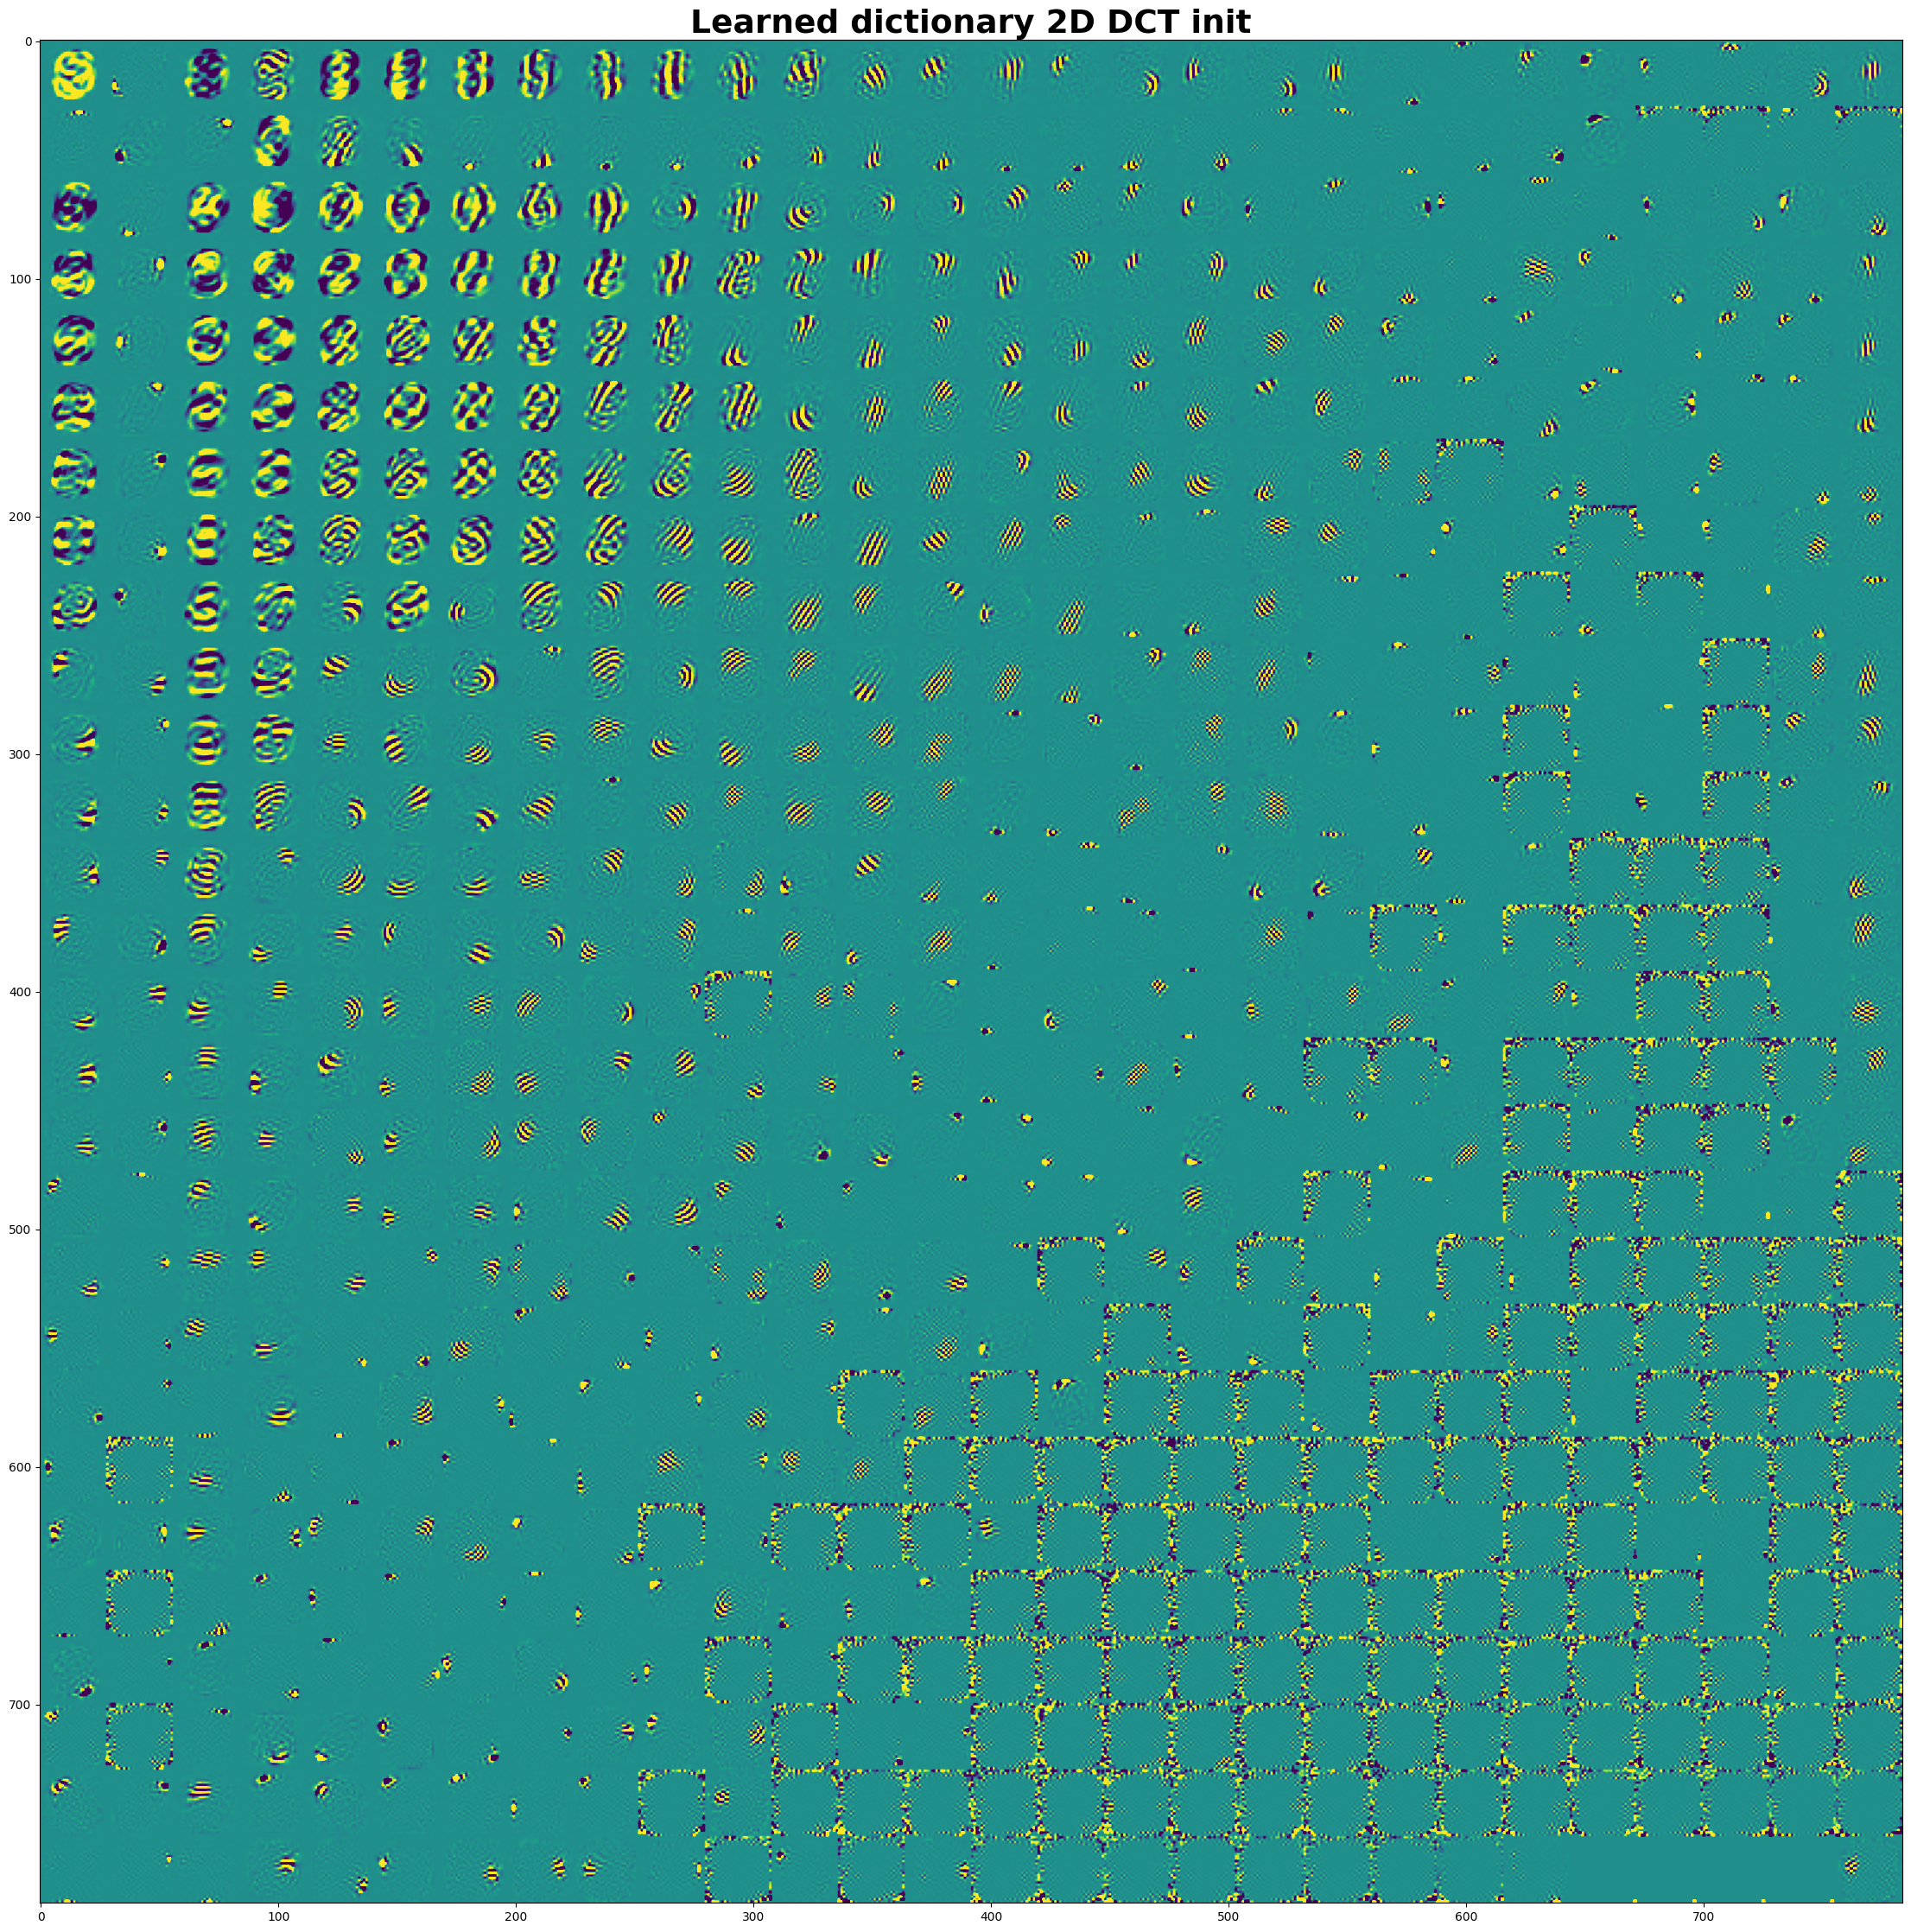

In [34]:
plt.figure(figsize=(28,28))
displayDictGrid(TrainDict.dict)
plt.clim([-0.05,0.05])
plt.title('Learned dictionary 2D DCT init',fontsize=27,fontweight='bold')
#plt.savefig('Learned_dict_init_2D_Dct.svg',format='svg',dpi=300)

In [35]:
recon=TrainDict.dict@TrainDict.proj

In [1]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
inds=1000
ax[0].imshow(xTrain[inds,:,:])
ax[1].imshow(recon[:,inds].reshape(28,28))


NameError: name 'plt' is not defined

In [ ]:
psnrDist=[]
for inds in range(xTrain.shape[0]):
    psnrDist.append(10*np.log10((255**2)/np.mean((xTrain[inds,:,:]-255.0*recon[:,inds].reshape(28,28))**2)))

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 1.000e+00, 1.000e+01,
        1.000e+01, 1.500e+01, 1.800e+01, 4.800e+01, 6.900e+01, 7.700e+01,
        1.250e+02, 2.030e+02, 2.410e+02, 3.410e+02, 3.740e+02, 4.990e+02,
        6.790e+02, 8.580e+02, 1.013e+03, 1.212e+03, 1.370e+03, 1.618e+03,
        1.740e+03, 1.946e+03, 2.163e+03, 2.264e+03, 2.450e+03, 2.469e+03,
        2.476e+03, 2.530e+03, 2.547e+03, 2.473e+03, 2.302e+03, 2.181e+03,
        2.139e+03, 1.933e+03, 1.790e+03, 1.624e+03, 1.390e+03, 1.297e+03,
        1.125e+03, 1.022e+03, 9.470e+02, 8.070e+02, 7.110e+02, 6.390e+02,
        5.490e+02, 4.650e+02, 4.040e+02, 3.280e+02, 3.650e+02, 2.920e+02,
        3.000e+02, 2.770e+02, 2.170e+02, 2.260e+02, 2.590e+02, 2.180e+02,
        2.360e+02, 2.360e+02, 2.500e+02, 2.400e+02, 2.240e+02, 2.440e+02,
        2.380e+02, 2.380e+02, 2.290e+02, 2.330e+02, 2.080e+02, 2.060e+02,
        1.970e+02, 1.730e+02, 1.690e+0

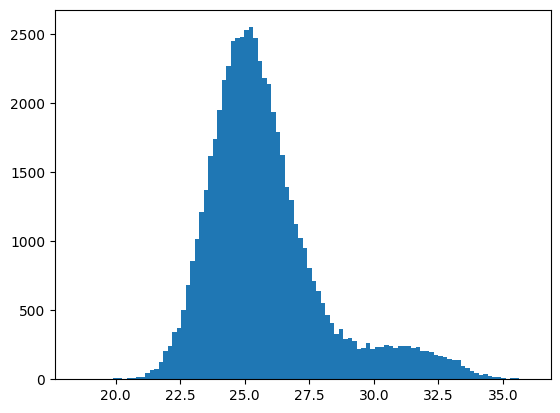

In [30]:
plt.hist(psnrDist,100)